# Mejor Ubicación Hospital

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.colors as mcolors
from scipy import integrate
from scipy.optimize import minimize
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

In [2]:
# np.inf distancia del maximo
def norma(x,orden=np.inf):
    return np.linalg.norm(x,orden)

def t(emergencia,hospital,alpha=1,beta=0,distance_order=np.inf):
    distancia=norma(np.array(emergencia)-np.array(hospital),distance_order)
    return alpha*distancia+beta

In [3]:
frequency = np.array([[ 0,2,3,1,1,1], 
                      [10,6,3,1,3,1],
                      [ 8,5,2,1,0,0],
                      [ 5,3,3,0,1,2],
                      [ 2,1,1,2,3,2],
                      [ 3,0,1,4,2,1]])

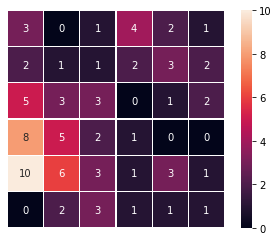

In [4]:
ax=sns.heatmap(frequency,annot=True,linewidths=.3,square=True,yticklabels=False,xticklabels=False).invert_yaxis()

In [5]:
means = []
for row in range(6):
    for col in range(6):
        means.append([row+0.5,  col+0.5])
means=np.array(means)
pi=frequency.reshape((36))/sum(sum(frequency))

def fdp(x):
    return 8/np.pi*sum(pi*np.exp(-8*((x[0]-means[:,0])**2+(x[1]-means[:,1])**2)))

In [6]:
step=0.025
X, Y = np.meshgrid(np.arange(0, 6., step), np.arange(0, 6., step))
x=X.reshape(X.shape[0]*X.shape[1])
y=Y.reshape(Y.shape[0]*Y.shape[1])
points=[i for i in zip(x,y)]

In [7]:
fdp_values=np.array(list(map(fdp,points)))

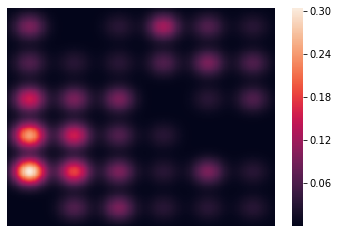

In [8]:
sns.heatmap(fdp_values.reshape(X.shape[0],X.shape[1]).T,yticklabels=False,xticklabels=False).invert_yaxis()

In [9]:
Z=fdp_values.reshape(X.shape[0],X.shape[1]).T
trace1 = go.Surface(z=Z, colorscale='Viridis')
iplot([trace1])

In [10]:
# Centro de masa
cm=[sum([i[0] for i in points]*fdp_values)/sum(fdp_values),sum([i[1] for i in points]*fdp_values)/sum(fdp_values)]
cm

[2.8393632439492764, 2.229772996312595]

In [11]:
def parameters(hospital=[3,3],alpha=1,beta=0,distance_order=np.inf):

    def integrando(y,x,hospital=hospital,alpha=alpha,beta=beta,distance_order=distance_order):
        return fdp([x,y])*t([x,y],hospital,alpha,beta,distance_order)
    
    return integrando

def integrar(x,alpha=1,beta=0,distance_order=np.inf):
    return integrate.dblquad(parameters(hospital=x,alpha=alpha,beta=beta,distance_order=distance_order), 0, 6, 0, 6)[0]

In [12]:
distance_order=2
alpha=1.4651821942
beta=0.46829754501

In [13]:
sol=minimize(integrar, [2,2],args=(alpha,beta,distance_order))
sol

      fun: 3.4635701445486893
 hess_inv: array([[1.59473646, 0.33165916],
       [0.33165916, 1.79492527]])
      jac: array([ 6.25848770e-06, -5.60283661e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([2.60871711, 1.78869343])

In [14]:
#integral=np.array([integrar([i,j]) for i,j in zip(x,y)]).reshape(X.shape[0],X.shape[1]).T

In [15]:
#sns.heatmap(integral).invert_yaxis()

In [16]:
def discreto(hospital,frequency,alpha=1,beta=0,distance_order=np.inf):
    return np.dot(frequency.flatten(),np.array([t(i,hospital,alpha,beta,distance_order) for i in means]))

In [17]:
sol_d=minimize(discreto, [2,2],args=(frequency,alpha,beta,np.inf))
sol_d

      fun: 259.3486923866156
 hess_inv: array([[ 1.83951681e-10, -2.78328991e-10],
       [-2.78328991e-10,  2.13129544e-02]])
      jac: array([17.9668541 , 13.18664169])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 360
      nit: 5
     njev: 88
   status: 2
  success: False
        x: array([2.57997963, 1.57997963])

In [18]:
hospital_1=sol.x
hospital_2=cm
hospital_3=sol_d.x

In [19]:
n_puntos_prueba=10000
puntos_prueba_uniforme=[points[np.random.choice(len(points))] for i in range(n_puntos_prueba)]
index=np.random.choice(np.arange(len(points)), n_puntos_prueba, p=fdp_values/sum(fdp_values))
puntos_prueba_fdp=[points[i] for i in index]

In [20]:
for h in [hospital_1,hospital_2,hospital_3]:
    print(np.mean([ t(puntos_prueba_uniforme[i],h,alpha,beta,distance_order=2) for i in range(n_puntos_prueba)]))

4.183635675788845
3.970250337832611
4.30343628841904


In [21]:
for h in [hospital_1,hospital_2,hospital_3]:
    print(np.mean([ t(puntos_prueba_fdp[i],h,alpha,beta,distance_order=2) for i in range(n_puntos_prueba)]))

3.5039044066285174
3.5597710844721377
3.51662090190022


In [85]:
f_disc=[discreto(i,frequency,alpha,beta,distance_order) for i in points]

In [86]:
A=np.array(f_disc).reshape(240,240)

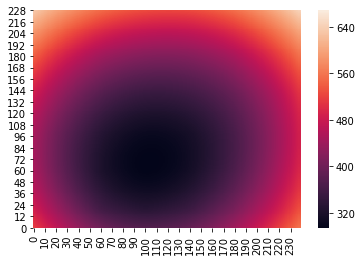

In [87]:
sns.heatmap(A).invert_yaxis()

In [88]:
trace1 = go.Surface(z=A, colorscale='Viridis')
iplot([trace1])

In [ ]:
f_cont=[integrar(x,alpha,beta,distance_order) for x in points]